<a href="https://colab.research.google.com/github/georgilos/Bert-for-text-classification/blob/main/SPAL%2BBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Cloning the repository containing itinial training data, evaluation & unlabeled data

In [1]:
!git clone https://github.com/georgilos/Bert-for-text-classification.git

Cloning into 'Bert-for-text-classification'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 187 (delta 23), reused 18 (delta 7), pack-reused 137 (from 1)
Receiving objects: 100% (187/187), 37.50 MiB | 25.31 MiB/s, done.
Resolving deltas: 100% (72/72), done.


### Changing to correct directory

In [2]:
%cd Bert-for-text-classification/

/content/Bert-for-text-classification


### Checking that we are in the correct directory and the data directories are present

In [5]:
%ls

Active+BERT.ipynb            evaluation_data/     requirements.txt         unlabeled_data/
active_learning_basics.py    LICENSE              SPAL+Bert.ipynb          unlabeled_embeddings.pt
active_learning.py           models/              train_embeddings.pt      validation_data/
advanced_active_learning.py  pytorch_clusters.py  training_data/
diversity_sampling.py        README.md            uncertainty_sampling.py


### Checking gpu is on

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Reading the .csv files


In [4]:
import pandas as pd

# Load training data
train_hate = pd.read_csv('training_data/related.csv', header=None)
train_non_hate = pd.read_csv('training_data/not_related.csv', header=None)

# Load evaluation data
eval_hate = pd.read_csv('evaluation_data/related.csv', header=None)
eval_non_hate = pd.read_csv('evaluation_data/not_related.csv', header=None)

# Load unlabeled data
unlabeled_data = pd.read_csv('unlabeled_data/unlabeled_data.csv', header=None)

# Assign column names
columns = ['ID', 'TEXT', 'LABEL', 'UNKNOWN1', 'UNKNOWN2']
train_hate.columns = train_non_hate.columns = eval_hate.columns = eval_non_hate.columns = columns
unlabeled_data.columns = ['ID', 'TEXT']  # Unlabeled data doesn't have LABEL

# Keep only relevant columns
train_hate = train_hate[['ID', 'TEXT', 'LABEL']]
train_non_hate = train_non_hate[['ID', 'TEXT', 'LABEL']]
eval_hate = eval_hate[['ID', 'TEXT', 'LABEL']]
eval_non_hate = eval_non_hate[['ID', 'TEXT', 'LABEL']]
unlabeled_data = unlabeled_data[['ID', 'TEXT']]  # Unlabeled data has no labels

# Combine training and evaluation data
train_data = pd.concat([train_hate, train_non_hate], ignore_index=True)
eval_data = pd.concat([eval_hate, eval_non_hate], ignore_index=True)

# Inspect the datasets
print("Training Data:")
print(train_data.head())
print("Evaluation Data:")
print(eval_data.head())
print("Unlabeled Data:")
print(unlabeled_data.head())


Training Data:
         ID                                               TEXT  LABEL
0  10241698  employees are either pedophiles or trying to r...      1
1  10238878  how about this lets go to retard war lets see ...      1
2  10119028                     lol you sick whiny tds pussies      1
3  10536279  she is a dumbass a public embarrassment for he...      1
4  10236262  i wanted to reply lets goooooo brandon but i d...      1
Evaluation Data:
       ID                                               TEXT  LABEL
0  585871  bitch i turn on the tv and is drunk af also ho...      1
1  215768  hicks and hillbillies are taking over the repu...      1
2  311431  the whole bunch is pure trash including the se...      1
3  452016  these gay drunk dudes on are very embarrassing...      1
4  109292  this dude is drunk af and crosseyed on in the ...      1
Unlabeled Data:
         ID                                               TEXT
0  10000000  if youre going down might as well go down in f..

###Checking an instance of the training data contents (not necessary)



In [30]:
print( train_data.iloc[9])

ID                                          10942227
TEXT     twitter is retarded and they aren't doctors
LABEL                                              1
Name: 9, dtype: object


### Finding Must - link pairs from the train_data

In [5]:
from itertools import combinations

def generate_must_link(data):
    same_class_pairs = []
    for label in data['LABEL'].unique():
        subset = data[data['LABEL'] == label]
        same_class_pairs.extend(list(combinations(subset.index, 2)))
    return same_class_pairs

must_link_pairs = generate_must_link(train_data)
print("First 5 Must-Link Pairs:", must_link_pairs[:5])  # Show first 5 pairs
print ("Totat Must-Link Pairs:", len(must_link_pairs))

First 5 Must-Link Pairs: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
Totat Must-Link Pairs: 3615


### Checking the contents of a must-link pair (not necessary)

In [9]:
# Access the contents of the first must-link pair
first_pair = must_link_pairs[0]
print("First Must-Link Pair Indices:", first_pair)

# Access the corresponding data points
first_pair_data = train_data.iloc[list(first_pair)]
print("\nData for the first Must-Link Pair:\n", first_pair_data)

First Must-Link Pair Indices: (0, 1)

Data for the first Must-Link Pair:
          ID                                               TEXT  LABEL
0  10241698  employees are either pedophiles or trying to r...      1
1  10238878  how about this lets go to retard war lets see ...      1


### Cannot-link pairs

In [6]:
def generate_cannot_link(data):
    hate_indices = data[data['LABEL'] == 1].index
    non_hate_indices = data[data['LABEL'] == 0].index
    return [(i, j) for i in hate_indices for j in non_hate_indices]

cannot_link_pairs = generate_cannot_link(train_data)
print("First 5 Cannot-Link Pairs:", cannot_link_pairs[:5])  # Show first 5 pairs
print ("Total Cannot-Link Pairs:", len(cannot_link_pairs))

First 5 Cannot-Link Pairs: [(0, 10), (0, 11), (0, 12), (0, 13), (0, 14)]
Total Cannot-Link Pairs: 850


### Checking the contents of a cannot-link pair (not necessary)

In [ ]:
# Access the contents of the first cannot-link pair
first_pair = cannot_link_pairs[0]
print("First Cannot-Link Pair Indices:", first_pair)

# Access the corresponding data points
first_pair_data = train_data.iloc[list(first_pair)]
print("\nData for the first Cannot-Link Pair:\n", first_pair_data)

First Cannot-Link Pair Indices: (0, 10)

Data for the first Cannot-Link Pair:
           ID                                               TEXT  LABEL
0   10241698  employees are either pedophiles or trying to r...      1
10  10410961          except on foreign soil not the same thing      0


### Creating the first BERT embeddings of the training and unlabeled data (not necessary if downloaded from previous sessions)

In [12]:
from transformers import BertTokenizer, BertModel
import torch


# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def generate_embeddings(texts, tokenizer, model, batch_size=16, use_cls=True):

    embeddings = []
    for i in range(0, len(texts), batch_size):  # Create batches
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        if use_cls:
            # Extract [CLS] token embedding
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
        else:
            # Apply mean pooling
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings)

    # Stack all embeddings into a single tensor
    return torch.cat(embeddings, dim=0)


# Generate embeddings for labeled data (train_data)
train_texts = train_data['TEXT'].tolist()
train_embeddings = generate_embeddings(train_texts, tokenizer, model, batch_size=16, use_cls=True)
print("Train Embeddings Shape:", train_embeddings.shape)

# Generate embeddings for unlabeled data
unlabeled_texts = unlabeled_data['TEXT'].tolist()
unlabeled_embeddings = generate_embeddings(unlabeled_texts, tokenizer, model, batch_size=16, use_cls=True)
print("Unlabeled Embeddings Shape:", unlabeled_embeddings.shape)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Train Embeddings Shape: torch.Size([95, 768])
Unlabeled Embeddings Shape: torch.Size([5001, 768])


### Saving  embeddings in the main directory

In [ ]:
# Save train embeddings
torch.save(train_embeddings, 'train_embeddings.pt')

# Save unlabeled embeddings
torch.save(unlabeled_embeddings, 'unlabeled_embeddings.pt')


### Download them to avoid recomputing them for future sessions

In [ ]:
from google.colab import files

files.download('/content/Bert-for-text-classification/unlabeled_embeddings.pt')
files.download('/content/Bert-for-text-classification/train_embeddings.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Load embeddings (if downloaded from last session)

In [7]:
import torch

# Paths to the saved .pt files
train_embeddings_path = 'train_embeddings.pt'
unlabeled_embeddings_path = 'unlabeled_embeddings.pt'

# Load the embeddings
train_embeddings = torch.load(train_embeddings_path)
unlabeled_embeddings = torch.load(unlabeled_embeddings_path)

print("Train Embeddings Shape:", train_embeddings.shape)
print("Unlabeled Embeddings Shape:", unlabeled_embeddings.shape)


Train Embeddings Shape: torch.Size([95, 768])
Unlabeled Embeddings Shape: torch.Size([5001, 768])


<ipython-input-7-dea01f3a36cb>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_embeddings = torch.load(train_embeddings_path)
<ipython-input-7-dea01f3a36cb>:9: Future

### Combine train and unlabeled embeddings into a single embedding

In [8]:
# Combine labeled and unlabeled embeddings
all_embeddings = torch.cat((train_embeddings, unlabeled_embeddings), dim=0)
print("Combined Embeddings Shape:", all_embeddings.shape)


Combined Embeddings Shape: torch.Size([5096, 768])


### Compute the pairwise distance matrix used for clustering (NumPy)

In [9]:
from scipy.spatial.distance import cdist
import numpy as np

# Convert embeddings to NumPy array if necessary
embeddings = all_embeddings.numpy()  # Combined embeddings from labeled and unlabeled data

# Compute pairwise distance matrix
distance_matrix = cdist(embeddings, embeddings, metric='cosine')
print("Distance Matrix Shape:", distance_matrix.shape)
print("Distance Matrix:", distance_matrix)

Distance Matrix Shape: (5096, 5096)
Distance Matrix: [[0.         0.24914965 0.20283401 ... 0.2177557  0.21595211 0.19677398]
 [0.24914965 0.         0.16507129 ... 0.13016856 0.25120268 0.23497529]
 [0.20283401 0.16507129 0.         ... 0.11977535 0.12581189 0.10162181]
 ...
 [0.2177557  0.13016856 0.11977535 ... 0.         0.17405549 0.15215808]
 [0.21595211 0.25120268 0.12581189 ... 0.17405549 0.         0.12088816]
 [0.19677398 0.23497529 0.10162181 ... 0.15215808 0.12088816 0.        ]]


### Plotting the values of distance matrix to select a suitable eps value

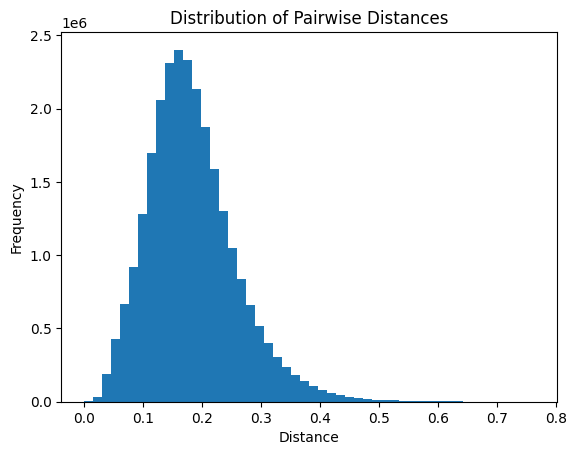

In [9]:
import matplotlib.pyplot as plt
plt.hist(distance_matrix.flatten(), bins=50)
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Pairwise Distances")
plt.show()

#### We can see that the most common distance is 0.15

### Constrained DBSCAN clustering function (with NumPy)


In [10]:
import numpy as np
from collections import deque

def constrained_dbscan_with_constraints(distance_matrix, eps, min_samples, must_link, cannot_link):
    """
    Constrained DBSCAN implementation where constraints are applied during clustering.

    Parameters:
    - distance_matrix (ndarray): Pairwise distance matrix.
    - eps (float): Maximum distance to consider two points as neighbors.
    - min_samples (int): Minimum number of neighbors for a point to be a core point.
    - must_link (list of tuples): List of must-link pairs (index1, index2).
    - cannot_link (list of tuples): List of cannot-link pairs (index1, index2).

    Returns:
    - labels (ndarray): Cluster labels for each point. Noise is labeled as -1.
    """
    n = distance_matrix.shape[0] # # Get the total number of data points (number of rows in the distance matrix).
    labels = np.full(n, -1)  # Initialize all points as noise (-1)
    cluster_id = 0 # Start with cluster ID 0

    # Convert must-link and cannot-link constraints into dictionaries for quick lookup
    must_link_dict = {i: set() for i in range(n)}
    for i, j in must_link:
        must_link_dict[i].add(j)
        must_link_dict[j].add(i)

    cannot_link_dict = {i: set() for i in range(n)}
    for i, j in cannot_link:
        cannot_link_dict[i].add(j)
        cannot_link_dict[j].add(i)

    # Visit each point
    visited = np.full(n, False) # Checks if a point is unvisited and not yet part of a cluster

    def expand_cluster(point_idx):
        # Initialising a double-ended queue to store points for Breadth-First Search
        queue = deque([point_idx]) # Add the index of the initial point to it
        cluster_points = [] # Points that will be part of this cluster

        while queue:
            current_point = queue.popleft() # Retrieve and remove the leftmost element from the queue
            if visited[current_point]: # If a point is visited
                continue #Skip this point
            visited[current_point] = True # If not visited, mark it as such
            cluster_points.append(current_point) # Add point to the cluster_points list

            # Get neighbors of the current point based on pre-calculated distances in distance_matrix.
            # Points within a distance of 'eps' are considered neighbors.
            # np.where(...) returns indices of neighbors (using [0]).
            neighbors = np.where(distance_matrix[current_point] <= eps)[0]

            # Ensure cannot-link constraints are not violated
            valid_neighbors = []
            for neighbor in neighbors:
                # Check for indirect cannot-link violations
                if any(
                    neighbor in cannot_link_dict[other_point] for other_point in cluster_points
                ):
                    continue  # Skip this neighbor, as it creates an indirect cannot-link violation
                valid_neighbors.append(neighbor)

            print(f"Point {current_point}: {len(neighbors)} neighbors before filtering, {len(valid_neighbors)} after filtering.")
            neighbors = valid_neighbors

            # Add must-link neighbors to the cluster and queue
            for p in must_link_dict[current_point]:
                if p not in cluster_points:
                    queue.append(p)

            # If the current point has enough neighbors, include them in the cluster
            if len(neighbors) >= min_samples:
                for neighbor in neighbors:
                    if neighbor not in cluster_points:
                        queue.append(neighbor)

        # Assign the cluster ID to all points in the cluster
        for p in cluster_points:
            labels[p] = cluster_id


    for i in range(n):
        if visited[i] or labels[i] != -1:  # Skip visited or already clustered points
            continue

        # Check if the point is a core point
        neighbors = np.where(distance_matrix[i] <= eps)[0]
        if len(neighbors) < min_samples:
            continue  # Not a core point, remains noise

        # Expand the cluster
        expand_cluster(i)
        cluster_id += 1

    return labels

### Executing constrained DBSCAN (with NumPy) (duration: 46 minutes)

In [11]:
# Apply constrained DBSCAN
eps = 0.15  # Adjust based on distance matrix
min_samples = 5  # Minimum neighbors to form a cluster

adjusted_labels = constrained_dbscan_with_constraints(distance_matrix, eps, min_samples, must_link_pairs, cannot_link_pairs)
print("Adjusted Cluster Labels:", np.unique(adjusted_labels))

Point 0: 21 neighbors before filtering, 20 after filtering.
Point 1: 183 neighbors before filtering, 182 after filtering.
Point 2: 3269 neighbors before filtering, 3231 after filtering.
Point 3: 1706 neighbors before filtering, 1686 after filtering.
Point 4: 735 neighbors before filtering, 728 after filtering.
Point 5: 2801 neighbors before filtering, 2769 after filtering.
Point 6: 3025 neighbors before filtering, 2986 after filtering.
Point 7: 813 neighbors before filtering, 803 after filtering.
Point 8: 43 neighbors before filtering, 43 after filtering.
Point 9: 699 neighbors before filtering, 691 after filtering.
Point 106: 2932 neighbors before filtering, 2890 after filtering.
Point 146: 2648 neighbors before filtering, 2605 after filtering.
Point 532: 2315 neighbors before filtering, 2278 after filtering.
Point 675: 821 neighbors before filtering, 809 after filtering.
Point 1062: 3177 neighbors before filtering, 3133 after filtering.
Point 1196: 506 neighbors before filtering, 497

### Visualisation of clustering (not necessary)

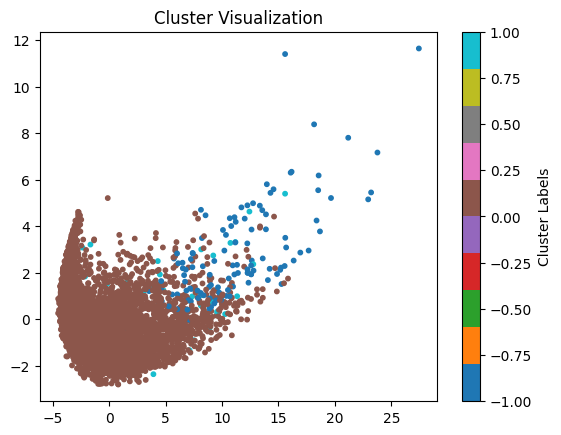

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
reduced_embeddings = PCA(n_components=2).fit_transform(distance_matrix)

# Plot clusters
plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1],
    c=adjusted_labels, cmap='tab10', s=10
)
plt.colorbar(label="Cluster Labels")
plt.title("Cluster Visualization")
plt.show()



### Checking for must-link & cannot-link violations (not necessary)

In [14]:
# Cannot-link violations
cannot_violations = [
    (i, j) for i, j in cannot_link_pairs if adjusted_labels[i] == adjusted_labels[j] and adjusted_labels[i] != -1
]
print(f"Cannot-Link Violations: {len(cannot_violations)}")

# Must-link violations
must_violations = [
    (i, j) for i, j in must_link_pairs if adjusted_labels[i] != adjusted_labels[j]
]
print(f"Must-Link Violations: {len(must_violations)}")


Cannot-Link Violations: 0
Must-Link Violations: 0


### Number of noise points (not necessary)

In [15]:
noise_points = [i for i, label in enumerate(adjusted_labels) if label == -1]
print(f"Number of Noise Points: {len(noise_points)}")


Number of Noise Points: 115


### Find the text of the first 15 instances of each cluster (not necessary)

In [16]:
import pandas as pd

all_texts = train_data['TEXT'].tolist() + unlabeled_data['TEXT'].tolist()

# Combine embeddings, labels, and texts into a DataFrame
clustered_data = pd.DataFrame({
    'TEXT': all_texts,
    'CLUSTER': adjusted_labels  # From clustering
})

# Group by clusters and inspect
for cluster_id in np.unique(adjusted_labels):
    pd.set_option('display.max_colwidth', None)  # Set to None for unlimited width
    print(f"\nCluster {cluster_id}:")
    print(clustered_data[clustered_data['CLUSTER'] == cluster_id].head(15))  # Inspect first 15 texts



Cluster -1:
                                                                                                                                                                                                                                                          TEXT  \
131                                                                                                                                                          pope francis has condemned violence against women as an insult to god in his new years day homily   
135                                                                                                                                                                                                                                                          …   
140                                                                                          yes eu blamed georgia for over reacting to sos attack on georgian villages ive acknowledged that eu also found russia br

### If it is not the first time performing clustering, we must now update the memory. Otherwise skip this step and proceed with memory initialation

In [ ]:
# def update_memory_bank(memory_bank, embeddings, cluster_labels):

### Function for memory bank initialization to store centroids used for Lc loss

In [17]:
def initialize_memory_bank(embeddings, cluster_labels):
    """
    Initialize the memory bank with cluster centroids (PyTorch version).

    Parameters:
    - embeddings (torch.Tensor): Embeddings of all data points (n x d).
    - cluster_labels (torch.Tensor): Cluster labels for each data point.

    Returns:
    - memory_bank (dict): A dictionary where keys are cluster IDs and values are centroids.
    """
    memory_bank = {}
    unique_clusters = torch.unique(cluster_labels[cluster_labels != -1])  # Exclude noise (-1)
    for cluster in unique_clusters:
        cluster_indices = torch.where(cluster_labels == cluster)[0]  # Find points in the cluster
        cluster_embeddings = embeddings[cluster_indices]  # Get embeddings for the cluster
        centroid = cluster_embeddings.mean(dim=0)  # Compute centroid
        memory_bank[int(cluster.item())] = centroid  # Store as tensor in memory bank
    return memory_bank


### Memory initialization

In [18]:
adjusted_labels= torch.tensor(adjusted_labels, dtype=torch.int64) # Making sure that adjusted_labels are PyToch tensors
memory_bank = initialize_memory_bank(all_embeddings, adjusted_labels)
print(f"Memory Bank Initialized: {memory_bank}")



Memory Bank Initialized: {0: tensor([-2.7918e-02,  1.2260e-01,  2.8147e-02, -4.4232e-02, -2.8501e-01,
        -2.8911e-01,  3.1160e-01,  4.8503e-01, -3.1411e-02, -2.1678e-01,
         1.4100e-01, -5.9163e-02, -4.4371e-02,  3.3635e-01,  6.8648e-02,
         4.0170e-02, -2.2681e-01,  3.2432e-01,  2.3903e-01, -3.6066e-02,
        -2.0745e-02, -3.2165e-01,  8.6712e-02, -1.0346e-01,  3.2755e-02,
        -9.8346e-02,  2.3880e-02, -1.5576e-01,  3.6875e-02,  1.1629e-01,
         1.5050e-02,  1.9402e-01, -1.9242e-01, -8.2960e-02,  1.3240e-01,
        -6.5563e-02,  1.5841e-01,  2.1887e-02,  9.7505e-02,  1.0497e-01,
        -1.3648e-01,  2.1113e-02,  9.6115e-02, -2.5418e-02, -6.0447e-02,
        -2.6929e-01, -2.5942e+00, -4.8656e-02, -1.3579e-01, -2.5432e-01,
         1.9320e-01, -1.7195e-01,  9.6580e-02,  2.2691e-01,  8.0650e-02,
         2.9152e-01, -3.0074e-01,  3.4690e-01, -3.4664e-02,  1.6040e-01,
         1.6401e-01,  1.9102e-02, -1.7229e-01,  2.2935e-02, -3.5241e-02,
         1.2630e-01, -

### Lc loss calculation function

In [19]:
import torch

def calculate_contrastive_loss(memory_bank, embeddings, cluster_labels, temperature=0.5):
    """
    Calculate the contrastive loss (L_c) based on instance-to-centroid contrastive loss.

    Parameters:
    - memory_bank (dict): Dictionary containing cluster centroids (keys: cluster labels, values: centroids).
    - embeddings (torch.Tensor): Current embeddings of the instances (shape: [n_instances, embedding_dim]).
    - cluster_labels (ndarray): Cluster labels for each instance (shape: [n_instances]).
    - temperature (float): Temperature factor (tau) for scaling the logits.

    Returns:
    - loss (torch.Tensor): Calculated contrastive loss.
    """
    # Filter out noise points (cluster label == -1)
    valid_indices = cluster_labels != -1
    valid_embeddings = embeddings[valid_indices]
    valid_labels = cluster_labels[valid_indices]

    # Prepare the centroids for all valid points
    # Change: Convert valid_labels elements to Python integers before using them as keys
    centroids = torch.stack([memory_bank[int(label.item())] for label in valid_labels])

    # Calculate logits: instance-to-centroid similarity
    logits = torch.mm(valid_embeddings, centroids.T) / temperature

    # Create the labels for the contrastive loss
    # Each instance is only "positive" with its own cluster centroid
    labels = torch.arange(len(valid_embeddings)).to(logits.device)

    # Calculate contrastive loss using CrossEntropyLoss
    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(logits, labels)

    return loss

### Lc loss computation

In [20]:
all_embeddings = all_embeddings.to(adjusted_labels.device)

contrastive_loss = calculate_contrastive_loss(memory_bank, all_embeddings, adjusted_labels, temperature=0.5)
print(f"Contrastive Loss: {contrastive_loss.item()}")


Contrastive Loss: 8.60744571685791


### Uncertain pairs extraction function

In [21]:
import numpy as np

def select_uncertain_pairs(distance_matrix, cluster_labels):
    """
    Select uncertain positive and negative pairs based on the clustering results and distance matrix.

    Parameters:
    - distance_matrix (ndarray): Pairwise distance matrix (n x n).
    - cluster_labels (ndarray): Cluster labels for each point.

    Returns:
    - uncertain_positive_pairs (list): List of (index1, index2, distance) for uncertain positive pairs.
    - uncertain_negative_pairs (list): List of (index1, index2, distance) for uncertain negative pairs.
    """
    uncertain_positive_pairs = []  # For storing uncertain positive pairs
    uncertain_negative_pairs = []  # For storing uncertain negative pairs

    unique_clusters = np.unique(cluster_labels[cluster_labels != -1])  # Ignore noise (-1)

    # Uncertain Positive Pairs
    for cluster in unique_clusters:
        cluster_indices = np.where(cluster_labels == cluster)[0]
        if len(cluster_indices) > 1:
            # Find the pair with the maximum distance within the cluster
            max_dist = -np.inf
            best_pair = None
            for i in cluster_indices:
                for j in cluster_indices:
                    if i < j:  # Avoid duplicate comparisons
                        dist = distance_matrix[i, j]
                        if dist > max_dist:
                            max_dist = dist
                            best_pair = (i, j, dist)
            if best_pair:
                uncertain_positive_pairs.append(best_pair)

    # Uncertain Negative Pairs
    for cluster1 in unique_clusters:
        for cluster2 in unique_clusters:
            if cluster1 < cluster2:  # Avoid duplicate comparisons
                cluster1_indices = np.where(cluster_labels == cluster1)[0]
                cluster2_indices = np.where(cluster_labels == cluster2)[0]
                # Find the pair with the minimum distance between the two clusters
                min_dist = np.inf
                best_pair = None
                for i in cluster1_indices:
                    for j in cluster2_indices:
                        dist = distance_matrix[i, j]
                        if dist < min_dist:
                            min_dist = dist
                            best_pair = (i, j, dist)
                if best_pair:
                    uncertain_negative_pairs.append(best_pair)

    return uncertain_positive_pairs, uncertain_negative_pairs


### Finding the uncertain pairs

In [22]:
# Select uncertain pairs
uncertain_positive_pairs, uncertain_negative_pairs = select_uncertain_pairs(distance_matrix, adjusted_labels)

# Display results
print("Uncertain Positive Pairs (within clusters):")
for pair in uncertain_positive_pairs[:10]:
    print(f"Pair: {pair[0]} and {pair[1]}, Distance: {pair[2]:.4f}")

print("\nUncertain Negative Pairs (across clusters):")
for pair in uncertain_negative_pairs[:10]:
    print(f"Pair: {pair[0]} and {pair[1]}, Distance: {pair[2]:.4f}")


Uncertain Positive Pairs (within clusters):
Pair: 3151 and 4820, Distance: 0.5935
Pair: 21 and 79, Distance: 0.5037

Uncertain Negative Pairs (across clusters):
Pair: 703 and 46, Distance: 0.0194


### Finding the text and cluster for specific instances isntances (not necessary)

In [ ]:
# Insances 3151 and 4820 where parts on an uncertain positive pair
# Insances 703 and 46 where parts on an uncertain negative pair

# Cluster label 3151 and 4820
print(f"Cluster Label: {adjusted_labels[46]}")

# Text
print(f"Text: {all_texts[46]}")


Cluster Label: 1
Text: very valid point


###  Uncertain pairs annotation and updating constraints function

In [23]:
def annotate_and_update_constraints(
    uncertain_positive_pairs, uncertain_negative_pairs,
    all_texts, must_link_pairs, cannot_link_pairs
):
    """
    Annotates uncertain pairs and updates must-link and cannot-link constraints.

    Parameters:
    - uncertain_positive_pairs (list): List of uncertain positive pairs (index1, index2, distance).
    - uncertain_negative_pairs (list): List of uncertain negative pairs (index1, index2, distance).
    - all_texts (list): List of texts corresponding to embeddings.
    - must_link_pairs (list): Existing list of must-link pairs (to be updated).
    - cannot_link_pairs (list): Existing list of cannot-link pairs (to be updated).

    Returns:
    - must_link_pairs: Updated must-link pairs.
    - cannot_link_pairs: Updated cannot-link pairs.
    """
    print("Annotating Uncertain Positive Pairs (Within Clusters):")
    for i, j, dist in uncertain_positive_pairs:
        print(f"\nPair: ({i}, {j}), Distance: {dist:.4f}")
        print(f"Text 1: {all_texts[i]}")
        print(f"Text 2: {all_texts[j]}")
        decision = input("Should these belong in the same cluster? (y/n): ").strip().lower()
        if decision == "y":
            must_link_pairs.append((i, j))
        elif decision == "n":
            cannot_link_pairs.append((i, j))

    print("\nAnnotating Uncertain Negative Pairs (Across Clusters):")
    for i, j, dist in uncertain_negative_pairs:
        print(f"\nPair: ({i}, {j}), Distance: {dist:.4f}")
        print(f"Text 1: {all_texts[i]}")
        print(f"Text 2: {all_texts[j]}")
        decision = input("Should these belong in different clusters? (y/n): ").strip().lower()
        if decision == "y":
            cannot_link_pairs.append((i, j))
        elif decision == "n":
            must_link_pairs.append((i, j))

    return must_link_pairs, cannot_link_pairs


### Uncertain pair annotation

In [24]:
all_texts = train_data['TEXT'].tolist() + unlabeled_data['TEXT'].tolist()

# Annotate the selected pairs
must_link_pairs, cannot_link_pairs = annotate_and_update_constraints(
    uncertain_positive_pairs, uncertain_negative_pairs,
    all_texts, must_link_pairs, cannot_link_pairs
)

# Confirm updates
print(f"Updated Must-Link Pairs: {len(must_link_pairs)}")
print(f"Updated Cannot-Link Pairs: {len(cannot_link_pairs)}")


Annotating Uncertain Positive Pairs (Within Clusters):

Pair: (3151, 4820), Distance: 0.5935
Text 1: f is colder than c…
Text 2: you stand up to nazis the same way you stand up to the ccp they dont have any right to hurt or murder you because of your skincolor ethnicity religion the nazis thought they had the right to gas children to death because no one stood up to them before it was too late peace
Should these belong in the same cluster? (y/n): n

Pair: (21, 79), Distance: 0.5037
Text 1: damn this man is handsome
Text 2: opium is a source of jobs and wealth for the poorest of poor of afghanistan opium production is worth about billion dollars
Should these belong in the same cluster? (y/n): y

Annotating Uncertain Negative Pairs (Across Clusters):

Pair: (703, 46), Distance: 0.0194
Text 1: very cool
Text 2: very valid point
Should these belong in different clusters? (y/n): n
Updated Must-Link Pairs: 3617
Updated Cannot-Link Pairs: 851


### Ensure that the new pairs have been added to the constraints lists (not necessary)

In [25]:
# Access the last 5 instances added to must_link_pairs and cannot_link_pairs
print("\nLast 5 Must-Link Pairs added:")
for pair in must_link_pairs[-5:]:
    print(pair)

print("\nLast 5 Cannot-Link Pairs added:")
for pair in cannot_link_pairs[-5:]:
    print(pair) #


Last 5 Must-Link Pairs added:
(92, 93)
(92, 94)
(93, 94)
(21, 79)
(703, 46)

Last 5 Cannot-Link Pairs added:
(9, 91)
(9, 92)
(9, 93)
(9, 94)
(3151, 4820)


### Lt support pair Loss function

In [26]:
import torch
import torch.nn.functional as F

def calculate_support_pair_loss(embeddings, must_link_pairs, cannot_link_pairs, margin=1.0):
    """
    Calculate the Support Pair Constraints Loss (L_t) based on must-link and cannot-link constraints.

    Parameters:
    - embeddings (torch.Tensor): Embedding matrix of shape (n_samples, embedding_dim).
    - must_link_pairs (list of tuples): List of (index1, index2) for must-link pairs.
    - cannot_link_pairs (list of tuples): List of (index1, index2) for cannot-link pairs.
    - margin (float): Margin for the triplet loss.

    Returns:
    - support_pair_loss (torch.Tensor): Calculated support pair loss (L_t).
    """
    triplet_losses = []

    for i in range(embeddings.shape[0]):  # Loop over all potential anchors
        # Find all must-link pairs for this anchor
        positives = [j for (a, j) in must_link_pairs if a == i] + [a for (a, j) in must_link_pairs if j == i]
        if not positives:  # Skip if no positives
            continue

        # Compute distances to all positives and find the hardest positive
        positive_distances = [torch.norm(embeddings[i] - embeddings[p], p=2) for p in positives]
        hardest_positive_idx = torch.argmax(torch.tensor(positive_distances))
        hardest_positive = embeddings[positives[hardest_positive_idx]]

        # Find all cannot-link pairs for this anchor
        negatives = [j for (a, j) in cannot_link_pairs if a == i] + [a for (a, j) in cannot_link_pairs if j == i]
        if not negatives:  # Skip if no negatives
            continue

        # Compute distances to all negatives and find the hardest negative
        negative_distances = [torch.norm(embeddings[i] - embeddings[n], p=2) for n in negatives]
        hardest_negative_idx = torch.argmax(torch.tensor(negative_distances))
        hardest_negative = embeddings[negatives[hardest_negative_idx]]

        # Compute triplet loss
        triplet_loss = F.relu(
            torch.norm(embeddings[i] - hardest_positive, p=2) - torch.norm(embeddings[i] - hardest_negative, p=2) + margin
        )
        triplet_losses.append(triplet_loss)

    # Average the triplet losses
    if len(triplet_losses) > 0:
        support_pair_loss = torch.stack(triplet_losses).mean()
    else:
        support_pair_loss = torch.tensor(0.0, requires_grad=True)

    return support_pair_loss


### Lt computation

In [27]:
# Calculate L_t using the updated constraints
support_pair_loss = calculate_support_pair_loss(all_embeddings, must_link_pairs, cannot_link_pairs, margin=1.0)

print(f"Support Pair Loss (L_t): {support_pair_loss}")


Support Pair Loss (L_t): 2.864370584487915


### Combined hybrid loss with λ=1




In [28]:
lambda_t = 1.0  # Weighting factor for L_t
combined_loss = contrastive_loss + lambda_t * support_pair_loss
print(f"Combined Loss: {combined_loss.item()}")


Combined Loss: 11.471816062927246


### Fine tuning bert with hybrid loss function

In [ ]:
import os
import torch
from transformers import BertTokenizer, BertModel

# Step 1: Initialize BERT and Optimizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Ensure all parameters of BERT are trainable
for param in model.parameters():
    param.requires_grad = True

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Step 2: Combine Losses (Assuming `contrastive_loss` and `support_pair_loss` have been calculated)
lambda_t = 1.0  # Weighting factor for L_t
combined_loss = contrastive_loss + lambda_t * support_pair_loss

# Debugging: Check if Combined Loss Requires Gradients
print(f"Combined Loss: {combined_loss.item()}")
print(f"Combined Loss requires_grad: {combined_loss.requires_grad}")


# Step 3: Enable Gradient Tracking for Losses
if not combined_loss.requires_grad:
    combined_loss = combined_loss.clone().detach().requires_grad_(True)

# Step 4: Perform Backpropagation and Weight Update
optimizer.zero_grad()  # Reset gradients
combined_loss.backward()  # Backpropagation
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"Gradient for {name}: {param.grad.norm().item()}")
    else:
        print(f"No gradient for {name}")

# Debugging: Ensure All Parameters Are Trainable
for name, param in model.named_parameters():
    print(f"{name}: requires_grad = {param.requires_grad}")


optimizer.step()  # Update BERT weights

# Step 5: Save the fine-tuned model
save_directory = "/content/Bert-for-text-classification/models"
os.makedirs(save_directory, exist_ok=True)  # Create the directory if it doesn't exist
save_path = os.path.join(save_directory, "fine_tuned_bert.pth")
torch.save(model, save_path)  # Save the model
print(f"Fine-tuned BERT model saved to {save_path}")

# Step 6: Print Updated Status
print(f"Combined Loss: {combined_loss.item()}")  # Monitor loss
print("BERT model weights updated and saved successfully.")


Combined Loss: 11.471816062927246
Combined Loss requires_grad: False
No gradient for embeddings.word_embeddings.weight
No gradient for embeddings.position_embeddings.weight
No gradient for embeddings.token_type_embeddings.weight
No gradient for embeddings.LayerNorm.weight
No gradient for embeddings.LayerNorm.bias
No gradient for encoder.layer.0.attention.self.query.weight
No gradient for encoder.layer.0.attention.self.query.bias
No gradient for encoder.layer.0.attention.self.key.weight
No gradient for encoder.layer.0.attention.self.key.bias
No gradient for encoder.layer.0.attention.self.value.weight
No gradient for encoder.layer.0.attention.self.value.bias
No gradient for encoder.layer.0.attention.output.dense.weight
No gradient for encoder.layer.0.attention.output.dense.bias
No gradient for encoder.layer.0.attention.output.LayerNorm.weight
No gradient for encoder.layer.0.attention.output.LayerNorm.bias
No gradient for encoder.layer.0.intermediate.dense.weight
No gradient for encoder.l

## **END OF RELATIVE CODE**
# Ignore the following

In [ ]:
# Debugging: Test Model Output and Gradient Flow
dummy_inputs = tokenizer(["This is a test sentence."], padding=True, truncation=True, return_tensors="pt").to(next(model.parameters()).device)
dummy_output = model(**dummy_inputs)
dummy_loss = dummy_output.last_hidden_state.sum()  # Simple dummy loss
dummy_loss.backward()

for name, param in model.named_parameters():
    if param.grad is not None:
        print(f"Gradient for {name}: {param.grad.norm().item()}")
    else:
        print(f"No gradient for {name}")


Gradient for embeddings.word_embeddings.weight: 236.25144958496094
Gradient for embeddings.position_embeddings.weight: 236.25146484375
Gradient for embeddings.token_type_embeddings.weight: 408.4272155761719
Gradient for embeddings.LayerNorm.weight: 13.956974029541016
Gradient for embeddings.LayerNorm.bias: 26.37604522705078
Gradient for encoder.layer.0.attention.self.query.weight: 43.33601760864258
Gradient for encoder.layer.0.attention.self.query.bias: 2.7903149127960205
Gradient for encoder.layer.0.attention.self.key.weight: 39.46836471557617
Gradient for encoder.layer.0.attention.self.key.bias: 7.370695698227792e-07
Gradient for encoder.layer.0.attention.self.value.weight: 120.17117309570312
Gradient for encoder.layer.0.attention.self.value.bias: 13.605146408081055
Gradient for encoder.layer.0.attention.output.dense.weight: 98.07749938964844
Gradient for encoder.layer.0.attention.output.dense.bias: 13.622260093688965
Gradient for encoder.layer.0.attention.output.LayerNorm.weight: 8.

### Generating the new embeddings based on the updated Bert

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

# Define paths
fine_tuned_model_path = "/content/Bert-for-text-classification/models/fine_tuned_bert.pth"

# Step 1: Load Fine-Tuned BERT Model
print("Loading the fine-tuned BERT model...")
model = torch.load(fine_tuned_model_path)
model.eval()  # Set the model to evaluation mode to avoid updating weights during inference

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Step 2: Function to Generate Embeddings
def generate_embeddings(texts, tokenizer, model, batch_size=16, use_cls=True):
    embeddings = []
    for i in range(0, len(texts), batch_size):  # Create batches
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
        with torch.no_grad():  # Disable gradient tracking for inference
            outputs = model(**inputs)
        if use_cls:
            # Extract [CLS] token embedding
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
        else:
            # Apply mean pooling
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings)

    # Stack all embeddings into a single tensor
    return torch.cat(embeddings, dim=0)

# Step 3: Generate Updated Embeddings
# Generate embeddings for labeled data
train_texts = train_data['TEXT'].tolist()
train_embeddings = generate_embeddings(train_texts, tokenizer, model, batch_size=16, use_cls=True)
print("Updated Train Embeddings Shape:", train_embeddings.shape)

# Generate embeddings for unlabeled data
unlabeled_texts = unlabeled_data['TEXT'].tolist()
unlabeled_embeddings = generate_embeddings(unlabeled_texts, tokenizer, model, batch_size=16, use_cls=True)
print("Updated Unlabeled Embeddings Shape:", unlabeled_embeddings.shape)

# Step 4: Save the Updated Embeddings by overwriting the older ones
torch.save(train_embeddings, '/content/Bert-for-text-classification/train_embeddings.pt')
torch.save(unlabeled_embeddings, '/content/Bert-for-text-classification/unlabeled_embeddings.pt')


Loading the fine-tuned BERT model...


<ipython-input-50-afe40a6afb44>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(fine_tuned_model_path)


Updated Train Embeddings Shape: torch.Size([95, 768])
Updated Unlabeled Embeddings Shape: torch.Size([5001, 768])


### Combine the embeddings

In [ ]:
# Combine labeled and unlabeled embeddings
all_embeddings = torch.cat((train_embeddings, unlabeled_embeddings), dim=0)
print("Combined Embeddings Shape:", all_embeddings.shape)

Combined Embeddings Shape: torch.Size([5096, 768])


### And the new distance matrix

In [ ]:
from scipy.spatial.distance import cdist
import numpy as np

# Convert embeddings to NumPy array if necessary
embeddings = all_embeddings.numpy()  # Combined embeddings from labeled and unlabeled data

# Compute pairwise distance matrix
distance_matrix = cdist(embeddings, embeddings, metric='cosine')
print("Distance Matrix Shape:", distance_matrix.shape)
print("Distance Matrix:", distance_matrix)

Distance Matrix Shape: (5096, 5096)
Distance Matrix: [[0.         0.24914965 0.20283401 ... 0.2177557  0.21595211 0.19677398]
 [0.24914965 0.         0.16507129 ... 0.13016856 0.25120268 0.23497529]
 [0.20283401 0.16507129 0.         ... 0.11977535 0.12581189 0.10162181]
 ...
 [0.2177557  0.13016856 0.11977535 ... 0.         0.17405549 0.15215808]
 [0.21595211 0.25120268 0.12581189 ... 0.17405549 0.         0.12088816]
 [0.19677398 0.23497529 0.10162181 ... 0.15215808 0.12088816 0.        ]]


### At this point we must perform clustering again using the updated distance matrix and must/cannot-link pairs

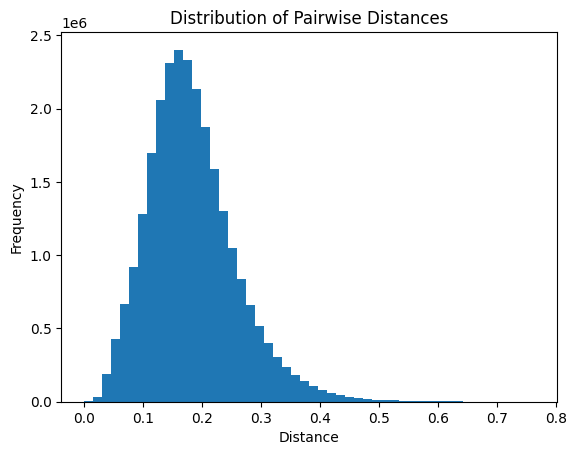

In [ ]:
import matplotlib.pyplot as plt
plt.hist(distance_matrix.flatten(), bins=50)
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Pairwise Distances")
plt.show()

### Comparing the weights of the updated and original BERT

In [ ]:
from transformers import BertModel
import torch

# Paths
fine_tuned_model_path = "/content/Bert-for-text-classification/models/fine_tuned_bert.pth"

# Load models
print("Loading the fine-tuned and original models...")
fine_tuned_model = torch.load(fine_tuned_model_path)
fine_tuned_model.eval()  # Set to evaluation mode

original_model = BertModel.from_pretrained('bert-base-uncased')
original_model.eval()  # Set to evaluation mode

# Compare weights
def compare_model_weights(model1, model2):
    """
    Compare weights of two models layer by layer.

    Parameters:
    - model1: First model (e.g., fine-tuned model).
    - model2: Second model (e.g., original model).

    Returns:
    - None (prints comparison results).
    """
    print("Comparing model weights...\n")
    for (name1, param1), (name2, param2) in zip(model1.named_parameters(), model2.named_parameters()):
        if name1 != name2:
            print(f"Layer mismatch: {name1} vs {name2}")
            continue

        if torch.equal(param1, param2):
            print(f"{name1}: Weights are identical.")
        else:
            diff = torch.norm(param1 - param2).item()
            print(f"{name1}: Weights differ by norm {diff:.6f}.")

# Perform comparison
compare_model_weights(fine_tuned_model, original_model)


Loading the fine-tuned and original models...


<ipython-input-53-fd7738b899cf>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fine_tuned_model = torch.load(fine_tuned_model_path)


Comparing model weights...

embeddings.word_embeddings.weight: Weights are identical.
embeddings.position_embeddings.weight: Weights are identical.
embeddings.token_type_embeddings.weight: Weights are identical.
embeddings.LayerNorm.weight: Weights are identical.
embeddings.LayerNorm.bias: Weights are identical.
encoder.layer.0.attention.self.query.weight: Weights are identical.
encoder.layer.0.attention.self.query.bias: Weights are identical.
encoder.layer.0.attention.self.key.weight: Weights are identical.
encoder.layer.0.attention.self.key.bias: Weights are identical.
encoder.layer.0.attention.self.value.weight: Weights are identical.
encoder.layer.0.attention.self.value.bias: Weights are identical.
encoder.layer.0.attention.output.dense.weight: Weights are identical.
encoder.layer.0.attention.output.dense.bias: Weights are identical.
encoder.layer.0.attention.output.LayerNorm.weight: Weights are identical.
encoder.layer.0.attention.output.LayerNorm.bias: Weights are identical.
enco

### Updating memory bank function

In [ ]:
def update_memory_bank(memory_bank, embeddings, cluster_labels):
    """
    Update the memory bank with recalculated centroids (PyTorch version).

    Parameters:
    - memory_bank (dict): Current memory bank with cluster centroids.
    - embeddings (torch.Tensor): Updated embeddings of all data points (n x d).
    - cluster_labels (torch.Tensor): Cluster labels for each data point.

    Returns:
    - memory_bank (dict): Updated memory bank with new centroids.
    """
    unique_clusters = torch.unique(cluster_labels[cluster_labels != -1])  # Exclude noise (-1)
    for cluster in unique_clusters:
        cluster_indices = torch.where(cluster_labels == cluster)[0]  # Find points in the cluster
        cluster_embeddings = embeddings[cluster_indices]  # Get embeddings for the cluster
        memory_bank[int(cluster.item())] = cluster_embeddings.mean(dim=0)  # Update centroid
    return memory_bank


### Calcuating new embeddings & updating memory bank

In [ ]:
import numpy as np

def generate_embeddings(texts, tokenizer, model, batch_size=16, use_cls=True):

    embeddings = []
    for i in range(0, len(texts), batch_size):  # Create batches
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, padding=True, truncation=True, return_tensors="pt", max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        if use_cls:
            # Extract [CLS] token embedding
            batch_embeddings = outputs.last_hidden_state[:, 0, :]
        else:
            # Apply mean pooling
            batch_embeddings = outputs.last_hidden_state.mean(dim=1)
        embeddings.append(batch_embeddings)

    # Stack all embeddings into a single tensor
    return torch.cat(embeddings, dim=0)

# Generate updated embeddings for labeled and unlabeled data
train_texts = train_data['TEXT'].tolist()
train_embeddings = generate_embeddings(train_texts, tokenizer, model, batch_size=16, use_cls=True)
unlabeled_texts = unlabeled_data['TEXT'].tolist()
unlabeled_embeddings = generate_embeddings(unlabeled_texts, tokenizer, model, batch_size=16, use_cls=True)

# Combine labeled and unlabeled embeddings
updated_embeddings = torch.cat((train_embeddings, unlabeled_embeddings), dim=0)
print("Updated Combined Embeddings Shape:", updated_embeddings.shape)

Updated Combined Embeddings Shape: torch.Size([5096, 768])


### Updating memory bank on new embeddings

In [ ]:
# Update the memory bank with new embeddings
memory_bank = update_memory_bank(memory_bank, updated_embeddings, adjusted_labels)
print("Memory Bank Updated Successfully.")


Memory Bank Updated Successfully.


In [ ]:
memory_bank

{0: array([-2.79185157e-02,  1.22595310e-01,  2.81470660e-02, -4.42324281e-02,
        -2.85009861e-01, -2.89107800e-01,  3.11602086e-01,  4.85026687e-01,
        -3.14107761e-02, -2.16776967e-01,  1.40995935e-01, -5.91631047e-02,
        -4.43704948e-02,  3.36352944e-01,  6.86481968e-02,  4.01698276e-02,
        -2.26809829e-01,  3.24316263e-01,  2.39027068e-01, -3.60664017e-02,
        -2.07451805e-02, -3.21645617e-01,  8.67116377e-02, -1.03463449e-01,
         3.27550694e-02, -9.83455479e-02,  2.38801464e-02, -1.55755118e-01,
         3.68748568e-02,  1.16294079e-01,  1.50498804e-02,  1.94020838e-01,
        -1.92422941e-01, -8.29599872e-02,  1.32395148e-01, -6.55628294e-02,
         1.58414707e-01,  2.18873583e-02,  9.75052267e-02,  1.04967371e-01,
        -1.36481702e-01,  2.11126525e-02,  9.61149707e-02, -2.54181568e-02,
        -6.04465827e-02, -2.69286096e-01, -2.59423327e+00, -4.86556925e-02,
        -1.35788187e-01, -2.54322350e-01,  1.93198085e-01, -1.71953022e-01,
         

### Fine tuning a saved model further

In [ ]:
import os
import torch
from transformers import BertTokenizer, BertModel

# Define paths
save_directory = "/content/Bert-for-text-classification/models"
fine_tuned_model_path = os.path.join(save_directory, "fine_tuned_bert.pth")

# Step 1: Initialize BERT and Optimizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

if os.path.exists(fine_tuned_model_path):
    print("Loading previously fine-tuned BERT model...")
    model = torch.load(fine_tuned_model_path)  # Load the previously fine-tuned model
    model.eval()  # Ensure it's in evaluation mode initially
else:
    print("No fine-tuned model found. Loading default BERT model...")
    model = BertModel.from_pretrained('bert-base-uncased')

# Ensure all parameters of BERT are trainable
for param in model.parameters():
    param.requires_grad = True

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Step 2: Combine Losses (Assuming `contrastive_loss` and `support_pair_loss` have been calculated)
lambda_t = 1.0  # Weighting factor for L_t
combined_loss = contrastive_loss + lambda_t * support_pair_loss

# Step 3: Enable Gradient Tracking for Losses
if not combined_loss.requires_grad:
    combined_loss = combined_loss.clone().detach().requires_grad_(True)

# Step 4: Perform Backpropagation and Weight Update
optimizer.zero_grad()  # Reset gradients
combined_loss.backward()  # Backpropagation
optimizer.step()  # Update BERT weights

# Step 5: Save the updated model
os.makedirs(save_directory, exist_ok=True)  # Create the directory if it doesn't exist
torch.save(model, fine_tuned_model_path)  # Save the model
print(f"Updated fine-tuned BERT model saved to {fine_tuned_model_path}")

# Step 6: Print Updated Status
print(f"Combined Loss: {combined_loss.item()}")  # Monitor loss
print("BERT model weights updated and saved successfully.")


### Main loop (not ready yet)

In [ ]:
# Hyperparameters
max_iterations = 10  # Maximum number of iterations
lambda_t = 1.0  # Weighting factor for L_t
tolerance = 1e-4  # Stopping threshold for clustering changes

# Initialize BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

# Start Iterative Process
for iteration in range(max_iterations):
    print(f"\n--- Iteration {iteration + 1} ---")

    # Step 1: Generate embeddings
    all_texts = train_data['TEXT'].tolist() + unlabeled_data['TEXT'].tolist()
    embeddings = generate_embeddings(all_texts, tokenizer, model, batch_size=16, use_cls=True)

    # Step 2: Clustering
    distance_matrix = compute_distance_matrix(embeddings)
    cluster_labels = constrained_dbscan_with_constraints(
        distance_matrix, eps=0.15, min_samples=5,
        must_link=must_link_pairs, cannot_link=cannot_link_pairs
    )
    print("Cluster Labels:", np.unique(cluster_labels))

    # Check if clustering has stabilized
    if iteration > 0 and np.all(previous_labels == cluster_labels):
        print("Clustering has stabilized. Stopping iterations.")
        break
    previous_labels = cluster_labels

    # Step 3: Annotate uncertain pairs
    uncertain_positive_pairs, uncertain_negative_pairs = select_uncertain_pairs(distance_matrix, cluster_labels)
    must_link_pairs, cannot_link_pairs = annotate_and_update_constraints(
        uncertain_positive_pairs, uncertain_negative_pairs,
        all_texts, must_link_pairs, cannot_link_pairs
    )

    # Step 4: Calculate Losses
    contrastive_loss = calculate_contrastive_loss(embeddings, cluster_labels, memory_bank)
    support_pair_loss = calculate_support_pair_loss(embeddings, must_link_pairs, cannot_link_pairs)
    combined_loss = contrastive_loss + lambda_t * support_pair_loss
    print(f"Combined Loss: {combined_loss.item()}")

    # Step 5: Fine-Tune BERT
    optimizer.zero_grad()
    combined_loss.backward()
    optimizer.step()

    # Step 6: Update Memory Bank
    memory_bank = update_memory_bank(memory_bank, embeddings, cluster_labels)

print("Iterative process complete.")
